In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.transforms as t

from sklearn.model_selection import train_test_split

from torchsummary import summary

import copy

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transformations = t.Compose([t.ToTensor(), t.Normalize(0.5, 0.5)])

In [4]:
emnist_train_set = torchvision.datasets.EMNIST(root="data", train=True, download=True, transform=transformations, split="letters")
emnist_test_set = torchvision.datasets.EMNIST(root="data", train=False, download=True, transform=transformations, split="letters")

In [5]:
emnist_train_images = emnist_train_set.data.view([emnist_train_set.data.shape[0], 1, 28, 28]).float()
emnist_test_images = emnist_test_set.data.view([emnist_test_set.data.shape[0], 1, 28, 28]).float()
print(emnist_train_images.shape, emnist_test_images.shape)

torch.Size([124800, 1, 28, 28]) torch.Size([20800, 1, 28, 28])


In [6]:
letter_categories = emnist_train_set.classes[1:]

emnist_train_labels = copy.deepcopy(emnist_train_set.targets) - 1
emnist_test_labels = copy.deepcopy(emnist_test_set.targets) - 1

print(len(emnist_train_labels), len(emnist_test_labels))
print(letter_categories)

124800 20800
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
emnist_train_images = emnist_train_images / torch.max(emnist_train_images)
emnist_test_images = emnist_test_images / torch.max(emnist_test_images)

In [8]:
emnist_train_data = TensorDataset(emnist_train_images, emnist_train_labels)
emnist_test_data = TensorDataset(emnist_test_images, emnist_test_labels)

emnist_train_loader = DataLoader(emnist_train_data, batch_size=128, shuffle=True, drop_last=True)
emnist_test_loader = DataLoader(emnist_test_data, batch_size=len(emnist_test_data))

In [9]:
def model():
    
    class CNN(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.conv1 = nn.Conv2d(1, 10, 5, 1, 1)
            self.b_norm1 = nn.BatchNorm2d(10)
            # (28 + 2*1 - 5)/1 + 1 = 26/2 = 13
            
            self.conv2 = nn.Conv2d(10, 15, 3, 1, 1)
            self.b_norm2 = nn.BatchNorm2d(15)
            # (13 + 2*1 - 3)/1 + 1 = 13/2 = 6
            
            self.conv3 = nn.Conv2d(15, 20, 3, 1, 1)
            self.b_norm3 = nn.BatchNorm2d(20)
            # (6 + 2*1 - 3)/1 + 1 = 6/2 = 3
            
            self.fc1 = nn.Linear(3*3*20, 250)
            
            self.fc2 = nn.Linear(250, 100)
            
            self.out = nn.Linear(100, 26)
            
        def forward(self, x):
            x = self.conv1(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm1(x)
            x = f.leaky_relu(x)
            
            x = self.conv2(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm2(x)
            x = f.leaky_relu(x)
            
            x = self.conv3(x)
            x = f.max_pool2d(x, 2)
            x = self.b_norm3(x)
            x = f.leaky_relu(x)
            
            num_units = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(num_units))
            
            x = self.fc1(x)
            x = f.leaky_relu(x)
            
            x = self.fc2(x)
            x = f.leaky_relu(x)
            
            x = self.out(x)
            x = f.relu(x)
            
            return x
    
    cnn = CNN()
    
    loss_fun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-5)
    
    return cnn, loss_fun, optimizer

In [10]:
summary(model()[0], (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
       BatchNorm2d-2           [-1, 10, 13, 13]              20
            Conv2d-3           [-1, 15, 13, 13]           1,365
       BatchNorm2d-4             [-1, 15, 6, 6]              30
            Conv2d-5             [-1, 20, 6, 6]           2,720
       BatchNorm2d-6             [-1, 20, 3, 3]              40
            Linear-7                  [-1, 250]          45,250
            Linear-8                  [-1, 100]          25,100
            Linear-9                   [-1, 26]           2,626
Total params: 77,411
Trainable params: 77,411
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.30
Estimated Total Size (MB): 0.40
---------------------------------------------

In [11]:
def train_model(cnn_model, loss_fun, optimizer, train_loader, test_loader, num_epochs = 20):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    cnn_model.to(device)

    for epoch in range(num_epochs):

        cnn_model.train()
        batch_loss = []
        batch_acc = []

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            y_hat = cnn_model(x)
            loss = loss_fun(y_hat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_hat = y_hat.cpu()
            y = y.cpu()

            batch_loss.append(loss.item())
            batch_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())

        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))

        cnn_model.eval()

        x, y = next(iter(test_loader))
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_hat = cnn_model(x)
            loss = loss_fun(y_hat, y)

        y_hat = y_hat.cpu()
        y = y.cpu()

        test_loss.append(loss.item())
        test_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()).item())

    del x
    torch.cuda.empty_cache()

    return train_acc, train_loss, test_acc, test_loss, cnn_model

In [12]:
emnist_cnn, loss_fun, optimizer = model()

train_acc, train_loss, test_acc, test_loss, emnist_cnn = train_model(emnist_cnn, loss_fun, optimizer, emnist_train_loader, emnist_test_loader)

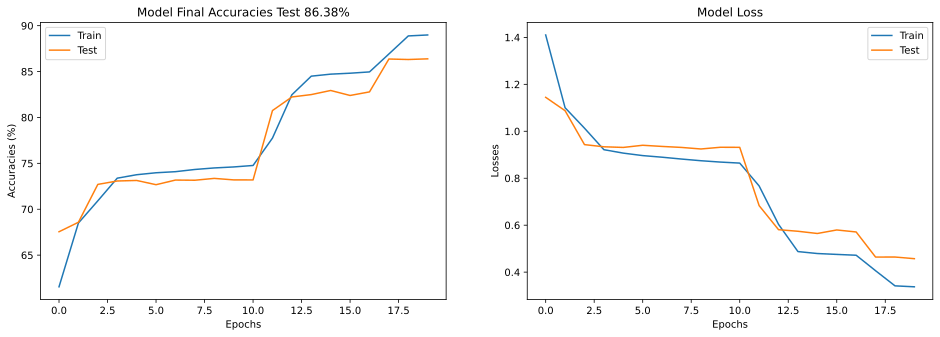

In [13]:
_, axis = plt.subplots(1, 2, figsize=(16, 5))

axis[0].plot(train_acc, "-", label="Train")
axis[0].plot(test_acc, "-", label="Test")
axis[0].set_title(f"Model Final Accuracies Test {test_acc[-1]:0.2f}%")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Accuracies (%)")
axis[0].legend()

axis[1].plot(train_loss, "-", label="Train")
axis[1].plot(test_loss, "-", label="Test")
axis[1].set_title("Model Loss")
axis[1].set_xlabel("Epochs")
axis[1].set_ylabel("Losses")
axis[1].legend();

In [14]:
mnist_train_set = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transformations)
mnist_test_set = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transformations)

In [15]:
mnist_train_images = mnist_train_set.data.view([mnist_train_set.data.shape[0], 1, 28, 28]).float()
mnist_test_images = mnist_test_set.data.view([mnist_test_set.data.shape[0], 1, 28, 28]).float()
print(mnist_train_images.shape, mnist_test_images.shape)

torch.Size([60000, 1, 28, 28]) torch.Size([10000, 1, 28, 28])


In [16]:
mnist_train_labels = mnist_train_set.targets
mnist_test_labels = mnist_test_set.targets
print(len(mnist_train_labels), "," , len(mnist_test_labels))

60000 , 10000


In [17]:
train_data = TensorDataset(mnist_train_images, mnist_train_labels)
test_data = TensorDataset(mnist_test_images, mnist_test_labels)

mnist_train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
mnist_test_loader = DataLoader(test_data, batch_size=len(test_data))

In [18]:
mnist_cnn_1, loss_fun, optimizer = model()
mnist_cnn_1.to(device)

for target, source in zip(mnist_cnn_1.named_parameters(), emnist_cnn.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data)

In [19]:
mnist_cnn_1.out.out_features = 10

In [20]:
train_acc, _, test_acc, _, mnist_cnn = train_model(mnist_cnn_1, loss_fun, optimizer, mnist_train_loader, mnist_test_loader, 1)

In [21]:
print(f"Train Accuracy: {train_acc[-1]:0.2f} and Test Accuracy: {test_acc[-1]:0.2f}")

Train Accuracy: 27.80 and Test Accuracy: 29.26


In [22]:
mnist_cnn_2, loss_fun, optimizer = model()
mnist_cnn_2.to(device)

for target, source in zip(mnist_cnn_2.named_parameters(), emnist_cnn.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data)

mnist_cnn_2.out.out_features = 10
mnist_cnn_2.conv1.requires_grad = False
mnist_cnn_2.b_norm1.requires_grad = False
mnist_cnn_2.conv2.requires_grad = False
mnist_cnn_2.b_norm2.requires_grad = False
mnist_cnn_2.conv3.requires_grad = False
mnist_cnn_2.b_norm3.requires_grad = False

In [23]:
train_acc, _, test_acc, _, mnist_cnn = train_model(mnist_cnn_2, loss_fun, optimizer, mnist_train_loader, mnist_test_loader, 1)

In [24]:
print(f"Train Accuracy: {train_acc[-1]:0.2f} and Test Accuracy: {test_acc[-1]:0.2f}")

Train Accuracy: 28.54 and Test Accuracy: 29.15
